In [1]:
import json
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from s4hci.utils.data_handling import load_adi_data, save_as_fits
from s4hci.models.psf_subtraction import S4
from s4hci.models.noise import S4Noise
from s4hci.utils.logging import print_message, setup_logger
from s4hci.utils.frame_selection import mse_frame_selection, \
    shift_frame_selection

from applefy.utils.file_handling import open_fits
from applefy.utils.fake_planets import add_fake_planets

# Load the data

In [2]:
# 2.) Load the dataset
print_message("Loading dataset")
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset="/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5",
        data_tag="object",  #13_object_final
        psf_template_tag="psf_template", #10_psf
        para_tag="header_object/PARANG")

science_data = science_data[:, 12:-12, 12:-12]

# Background subtraction of the PSF template
psf_template_data = np.median(raw_psf_template_data, axis=0)
psf_template_data = psf_template_data - np.min(psf_template_data)

In [3]:
fake_planet_config_file = "/fast/mbonse/s4/70_results/07_partial_contrast_grid/HD22049_303_199_C-0065_C_/configs_cgrid/exp_ID_0105c.json"
with open(fake_planet_config_file) as json_file:
    fake_planet_config = json.load(json_file)

data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template_data,
    parang=raw_angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

# All files we need

In [4]:
normalization_model_old = "/fast/mbonse/s4/70_results/06_contrast_curves/01_train_each_model_once/HD22049_303_199_C-0065_C_/models/normalization_model.pkl"
noise_model_old = "/fast/mbonse/s4/70_results/06_contrast_curves/01_train_each_model_once/HD22049_303_199_C-0065_C_/models/noise_model_fine_tuned.pkl"

In [5]:
normalization_model_new = "/fast/mbonse/s4/70_results/07_partial_contrast_grid/HD22049_303_199_C-0065_C_/models/0105c/normal/models/normalization_model.pkl"
noise_model_new = "/fast/mbonse/s4/70_results/07_partial_contrast_grid/HD22049_303_199_C-0065_C_/models/0105c/normal/models/noise_model_raw.pkl"

# Restore the S4 model trained on no planet

In [6]:
s4_model1 = S4.create_from_checkpoint(
    noise_model_file=noise_model_old,
    normalization_model_file=normalization_model_old,
    s4_work_dir=None,
    science_data=data_with_fake_planet,
    parang=raw_angles,
    psf_template=psf_template_data,
    device=0,
    verbose=True,
    planet_convolve_second=True,
    planet_use_up_sample=1)

S4 model: restoring models ... [DONE]


In [7]:
residual_1 = s4_model1.compute_residual(
    account_for_planet_model=False,
    combine="mean")

S4 model: computing residual ... [DONE]


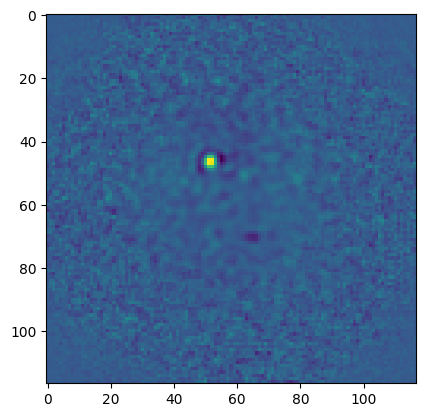

In [8]:
plt.imshow(residual_1)

# Restore the S4 model trained with planet

In [9]:
s4_model2 = S4.create_from_checkpoint(
    noise_model_file=noise_model_new,
    normalization_model_file=normalization_model_new,
    s4_work_dir=None,
    science_data=data_with_fake_planet,
    parang=raw_angles,
    psf_template=psf_template_data,
    device=0,
    verbose=True,
    planet_convolve_second=True,
    planet_use_up_sample=1)

S4 model: restoring models ... [DONE]


In [10]:
residual_2 = s4_model2.compute_residual(
    account_for_planet_model=False,
    combine="mean")

S4 model: computing residual ... [DONE]


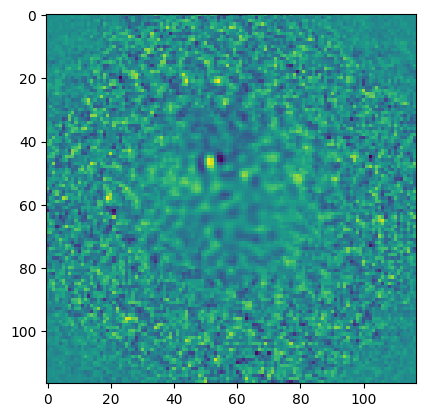

In [11]:
plt.imshow(residual_2)

# Restore the new noise but old normalization

In [12]:
s4_model3 = S4.create_from_checkpoint(
    noise_model_file=noise_model_new,
    normalization_model_file=normalization_model_old,
    s4_work_dir=None,
    science_data=data_with_fake_planet,
    parang=raw_angles,
    psf_template=psf_template_data,
    device=0,
    verbose=True,
    planet_convolve_second=True,
    planet_use_up_sample=1)

S4 model: restoring models ... [DONE]


In [13]:
residual_3 = s4_model3.compute_residual(
    account_for_planet_model=False,
    combine="mean")

S4 model: computing residual ... [DONE]


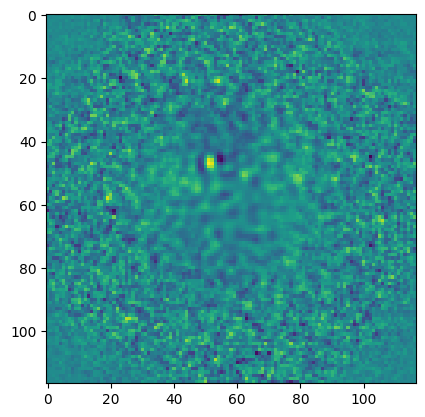

In [14]:
plt.imshow(residual_3)

# Residual of model2 without any planets

In [15]:
s4_model4 = S4.create_from_checkpoint(
    noise_model_file=noise_model_new,
    normalization_model_file=normalization_model_new,
    s4_work_dir=None,
    science_data=science_data,
    parang=raw_angles,
    psf_template=psf_template_data,
    device=0,
    verbose=True,
    planet_convolve_second=True,
    planet_use_up_sample=1)

S4 model: restoring models ... [DONE]


In [16]:
residual_4 = s4_model4.compute_residual(
    account_for_planet_model=False,
    combine="mean")

S4 model: computing residual ... [DONE]


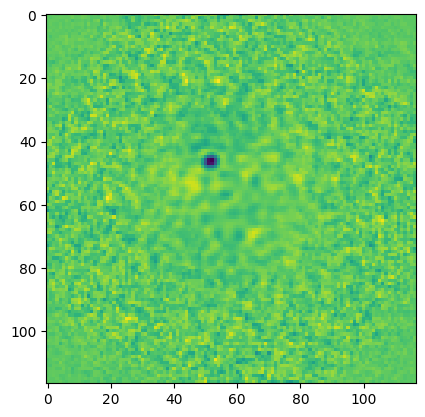

In [17]:
plt.imshow(residual_4)

# some random noise

In [19]:
s4_model5 = S4.create_from_checkpoint(
    noise_model_file=noise_model_new,
    normalization_model_file=normalization_model_new,
    s4_work_dir=None,
    science_data=science_data - np.random.randn(*science_data.shape),
    parang=raw_angles,
    psf_template=psf_template_data,
    device=0,
    verbose=True,
    planet_convolve_second=True,
    planet_use_up_sample=1)

S4 model: restoring models ... [DONE]


In [20]:
residual_5 = s4_model5.compute_residual(
    account_for_planet_model=False,
    combine="mean")

S4 model: computing residual ... [DONE]


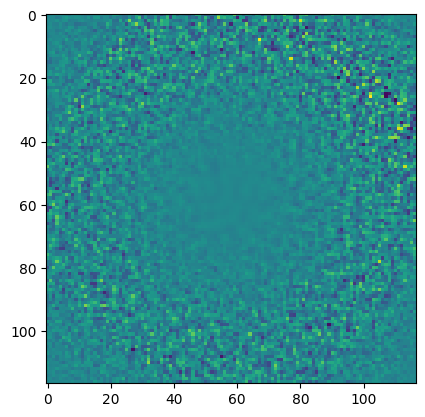

In [188]:
plt.imshow(residual_5)

# Compare the weights of model1 and model2

In [121]:
import torch

In [122]:
betas1 = s4_model1.noise_model.betas
betas1 = betas1.view(117, 117, 117, 117)

betas2 = s4_model2.noise_model.betas
betas2 = betas2.view(117, 117, 117, 117)

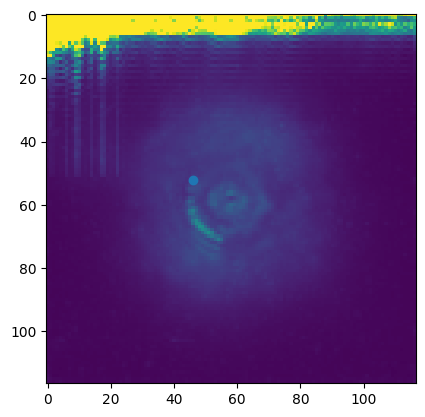

In [141]:
difference = (betas1 - betas2)**2
difference = difference.mean(axis=(0, 1)).view(117, 117)

plt.imshow(difference, vmin=0, vmax=5e-8)
plt.scatter([46],[52])

In [146]:
torch.where(difference[30:-30, 30:-30] == difference[30:-30, 30:-30].max())

(tensor([37]), tensor([18]))

In [192]:
beta1_sel = betas1[:, :, 30:-30, 30:-30][:, :, 37, 18]
beta2_sel = betas2[:, :, 30:-30, 30:-30][:, :, 37, 18]

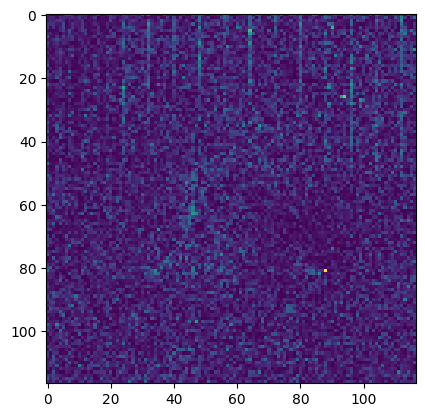

In [194]:
plt.imshow((beta1_sel-beta2_sel).abs())